Coat-Lite-Medium with cutmix applied

Epoch 1/5: 100%|██████████| 225/225 [15:38<00:00,  4.17s/it]


Epoch 1: Train Acc: 61.94%, Val Acc: 94.40%


Epoch 2/5: 100%|██████████| 225/225 [13:01<00:00,  3.48s/it]


Epoch 2: Train Acc: 73.51%, Val Acc: 96.40%


Epoch 3/5: 100%|██████████| 225/225 [22:04<00:00,  5.89s/it]


Epoch 3: Train Acc: 75.01%, Val Acc: 98.00%


Epoch 4/5: 100%|██████████| 225/225 [19:07<00:00,  5.10s/it]


Epoch 4: Train Acc: 75.71%, Val Acc: 97.60%


Epoch 5/5: 100%|██████████| 225/225 [20:24<00:00,  5.44s/it]


Epoch 5: Train Acc: 78.10%, Val Acc: 96.80%


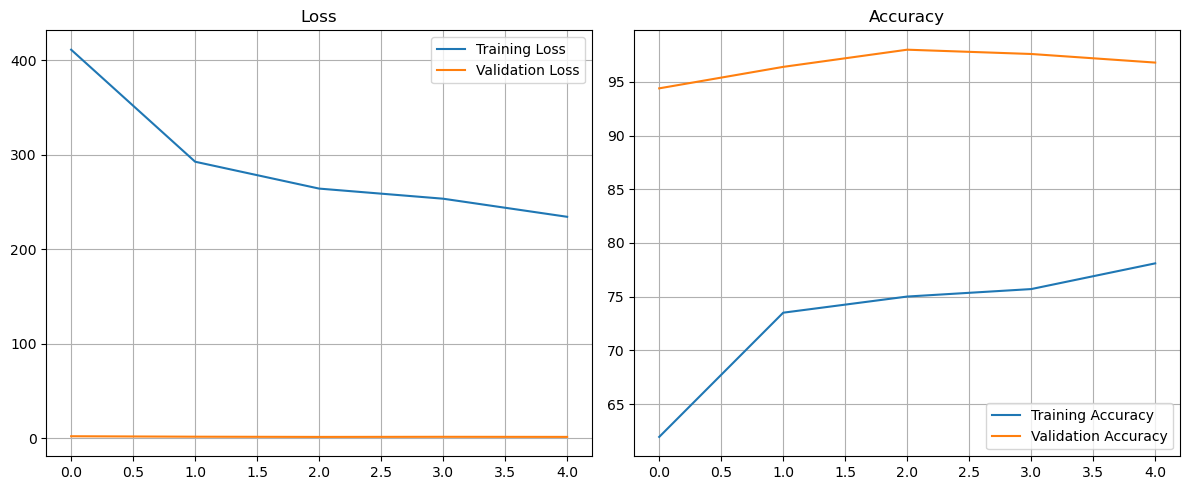

Test Accuracy: 98.80%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       0.83      1.00      0.91         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.60      0.75         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [30]:
# Import necessary libraries
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix  
from timm import create_model

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Transforms - standard normalization used for ImageNet pretrained weights
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup
data_transforms = {
    'train': transform,
    'valid': transform,
    'test': transform
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 blocks of serial_blocks4 + norm4 + head 
for name, param in model.named_parameters():
    if any([k in name for k in ["serial_blocks4.5", "serial_blocks4.6", "serial_blocks4.7", "norm4", "head"]]):
        param.requires_grad = True

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [31]:
torch.save(model.state_dict(), "coat_lite_cutmix_only.pth")

In [55]:
import torch
import timm
from torchvision import transforms
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image
import cv2
from pathlib import Path

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model 
model = timm.create_model('coat_lite_medium', pretrained=False, num_classes=50)
model.load_state_dict(torch.load("coat_lite_cutmix_only.pth", map_location=device))
model.to(device)
model.eval()

# Use the best target layer
target_layers = [model.serial_blocks4[7].cpe.proj]

# Load and preprocess image
image_path = "../data/kaggle-dataset/archive/test/ROSY MAPLE MOTH/3.jpg"
image = Image.open(image_path).convert("RGB")
rgb_img = np.array(image.resize((224, 224))) / 255.0  

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

input_tensor = transform(image).unsqueeze(0).to(device)

# Generate Score-CAM
cam = ScoreCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor)[0]

# Create visualization
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

# Save 
output_path = Path("../cam_outputs/coat_lite_ft/score-cam-cutmix-rosy-maple-3.jpg")
cv2.imwrite(str(output_path), visualisation)  


100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


True

In [ ]:
import torch
import timm
from torchvision import transforms
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image
import cv2
from pathlib import Path

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model 
model = timm.create_model('coat_lite_medium', pretrained=False, num_classes=50)
model.load_state_dict(torch.load("coat_lite_cutmix_only.pth", map_location=device))
model.to(device)
model.eval()

# Use the best target layer
target_layers = [model.serial_blocks4[7].cpe.proj]

# Load and preprocess image
image_path = "../data/kaggle-dataset/archive/test/ROSY MAPLE MOTH/2.jpg"
image = Image.open(image_path).convert("RGB")
rgb_img = np.array(image.resize((224, 224))) / 255.0  

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

input_tensor = transform(image).unsqueeze(0).to(device)

# Generate Score-CAM
cam = ScoreCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor)[0]

# Create visualization
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

# Save 
output_path = Path("../cam_outputs/coat_lite_ft/score-cam-cutmix-rosy-maple-2.jpg")
cv2.imwrite(str(output_path), visualisation)  


Coat Lite Medium with cutmix and standard transformations applied:

Epoch 1/5: 100%|██████████| 225/225 [27:42<00:00,  7.39s/it]


Epoch 1: Train Acc: 64.19%, Val Acc: 93.60%


Epoch 2/5: 100%|██████████| 225/225 [25:10<00:00,  6.71s/it]


Epoch 2: Train Acc: 73.56%, Val Acc: 95.60%


Epoch 3/5: 100%|██████████| 225/225 [16:29<00:00,  4.40s/it]


Epoch 3: Train Acc: 73.42%, Val Acc: 97.20%


Epoch 4/5: 100%|██████████| 225/225 [16:31<00:00,  4.41s/it]


Epoch 4: Train Acc: 75.21%, Val Acc: 96.40%


Epoch 5/5: 100%|██████████| 225/225 [16:38<00:00,  4.44s/it]


Epoch 5: Train Acc: 77.43%, Val Acc: 96.80%


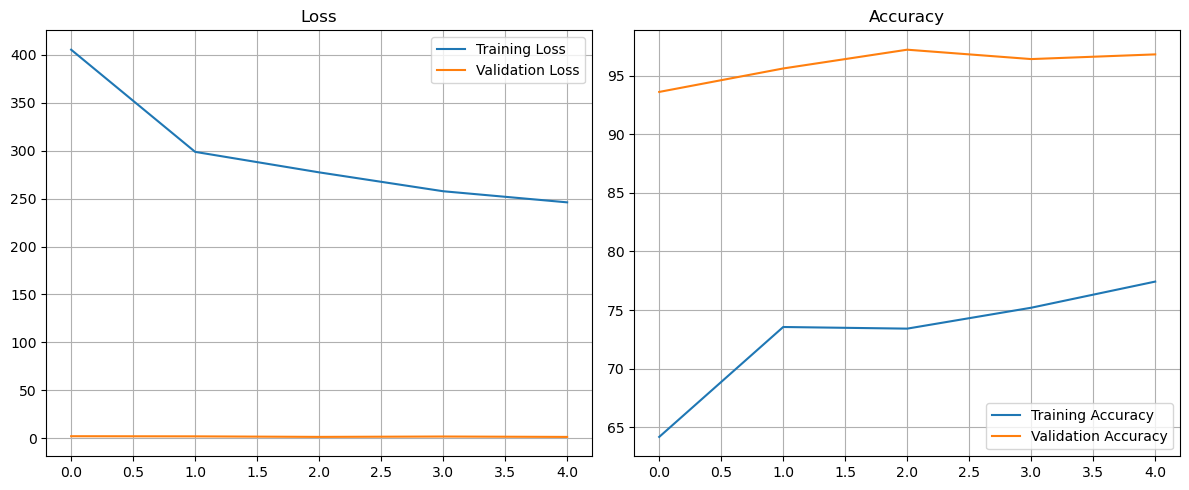

Test Accuracy: 98.00%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       0.83      1.00      0.91         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       0.83      1.00      0.91         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [32]:
# Import necessary libraries
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix  
from timm import create_model

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 blocks of serial_blocks4 + norm4 + head 
for name, param in model.named_parameters():
    if any([k in name for k in ["serial_blocks4.5", "serial_blocks4.6", "serial_blocks4.7", "norm4", "head"]]):
        param.requires_grad = True

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [33]:
torch.save(model.state_dict(), "coat_lite_standard_augmentations.pth")

In [9]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = timm.create_model('coat_lite_medium', pretrained=False, num_classes=50)
model.load_state_dict(torch.load("coat_lite_cutmix_augmentation.pth", map_location=device))
model.to(device)
model.eval()

# Target Layer: final projection layer of last serial block
target_layers = [model.patch_embed4.proj]

# Load and preprocess image
image_path = "../data/kaggle-dataset/archive/test/CLEARWING MOTH/1.jpg"
image = Image.open(image_path).convert("RGB")
rgb_img = np.array(image.resize((224, 224))) / 255.0  

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Initialise Score-CAM
cam = ScoreCAM(model=model, target_layers=target_layers)

# Generate CAM
grayscale_cam = cam(input_tensor=input_tensor)[0]
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/coat_lite_ft/score-cam-clearwing-1-cutmix-augmentation.jpg")
output_path.parent.mkdir(parents=True, exist_ok=True)
cv2.imwrite(str(output_path), visualisation)


100%|██████████| 32/32 [01:11<00:00,  2.23s/it]


True

Further transformations will be applied to the commonly confused species pairs

Epoch 1/5: 100%|██████████| 591/591 [40:43<00:00,  4.13s/it]


Epoch 1: Train Acc: 70.73%, Val Acc: 97.20%


Epoch 2/5: 100%|██████████| 591/591 [39:07<00:00,  3.97s/it]


Epoch 2: Train Acc: 77.29%, Val Acc: 95.20%


Epoch 3/5: 100%|██████████| 591/591 [39:07<00:00,  3.97s/it]


Epoch 3: Train Acc: 75.99%, Val Acc: 96.00%


Epoch 4/5: 100%|██████████| 591/591 [39:16<00:00,  3.99s/it]


Epoch 4: Train Acc: 79.20%, Val Acc: 96.40%


Epoch 5/5: 100%|██████████| 591/591 [38:42<00:00,  3.93s/it]


Epoch 5: Train Acc: 80.33%, Val Acc: 93.20%


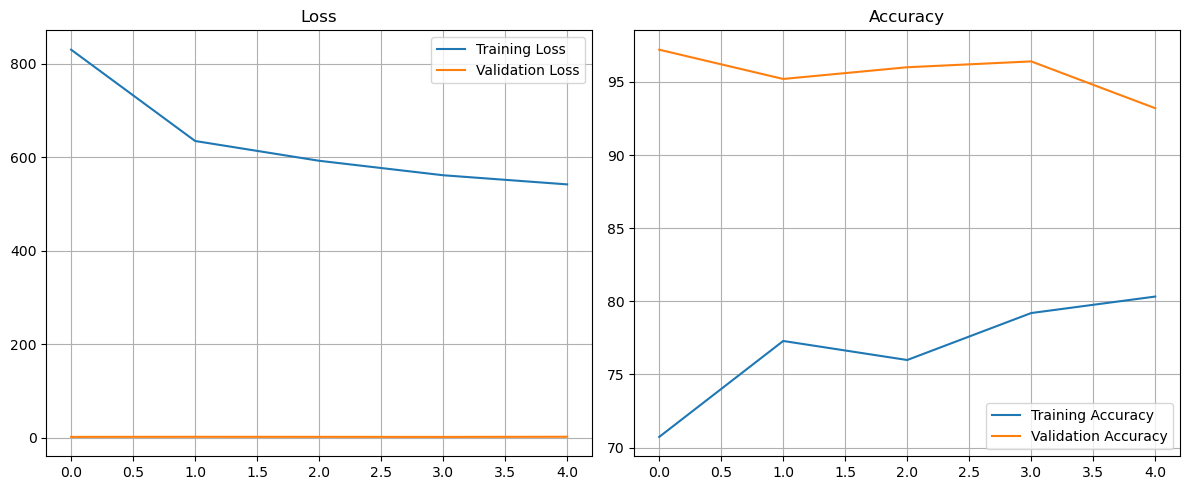

Test Accuracy: 95.20%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       0.00      0.00      0.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       0.71      1.00      0.83         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

c:\Users\rebec\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rebec\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rebec\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# Import necessary libraries
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix  
from timm import create_model

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/targeted_augmented_dataset")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 blocks of serial_blocks4 + norm4 + head 
for name, param in model.named_parameters():
    if any([k in name for k in ["serial_blocks4.5", "serial_blocks4.6", "serial_blocks4.7", "norm4", "head"]]):
        param.requires_grad = True

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [35]:
torch.save(model.state_dict(), "coat_lite_final_augmentations.pth")

Enhanced fine-tuning: 12,636,210/44,083,698 trainable params (28.7%)


Epoch 1/15: 100%|██████████| 591/591 [3:42:58<00:00, 22.64s/it]      


Epoch 1: Train Acc: 72.04%, Val Acc: 97.20%


Epoch 2/15: 100%|██████████| 591/591 [44:36<00:00,  4.53s/it]


Epoch 2: Train Acc: 78.29%, Val Acc: 94.80%


Epoch 3/15: 100%|██████████| 591/591 [46:58<00:00,  4.77s/it]


Epoch 3: Train Acc: 77.57%, Val Acc: 96.40%


Epoch 4/15: 100%|██████████| 591/591 [56:16<00:00,  5.71s/it]


Epoch 4: Train Acc: 80.61%, Val Acc: 97.20%


Epoch 5/15: 100%|██████████| 591/591 [45:23<00:00,  4.61s/it] 


Epoch 5: Train Acc: 81.80%, Val Acc: 96.80%


Epoch 6/15: 100%|██████████| 591/591 [43:09<00:00,  4.38s/it]


Epoch 6: Train Acc: 82.58%, Val Acc: 96.00%


Epoch 7/15: 100%|██████████| 591/591 [44:16<00:00,  4.50s/it]


Epoch 7: Train Acc: 82.17%, Val Acc: 97.60%


Epoch 8/15: 100%|██████████| 591/591 [44:57<00:00,  4.56s/it]


Epoch 8: Train Acc: 86.35%, Val Acc: 97.60%


Epoch 9/15: 100%|██████████| 591/591 [44:43<00:00,  4.54s/it]


Epoch 9: Train Acc: 86.50%, Val Acc: 97.20%


Epoch 10/15: 100%|██████████| 591/591 [51:04<00:00,  5.18s/it]


Epoch 10: Train Acc: 86.56%, Val Acc: 97.20%


Epoch 11/15: 100%|██████████| 591/591 [1:01:52<00:00,  6.28s/it]


Epoch 11: Train Acc: 86.59%, Val Acc: 97.20%


Epoch 12/15: 100%|██████████| 591/591 [1:20:25<00:00,  8.16s/it]


Epoch 12: Train Acc: 87.88%, Val Acc: 97.20%


Epoch 13/15: 100%|██████████| 591/591 [49:06<00:00,  4.98s/it] 


Epoch 13: Train Acc: 86.16%, Val Acc: 97.20%


Epoch 14/15: 100%|██████████| 591/591 [47:05<00:00,  4.78s/it]


Epoch 14: Train Acc: 87.56%, Val Acc: 97.20%


Epoch 15/15: 100%|██████████| 591/591 [46:57<00:00,  4.77s/it]


Epoch 15: Train Acc: 89.72%, Val Acc: 97.60%


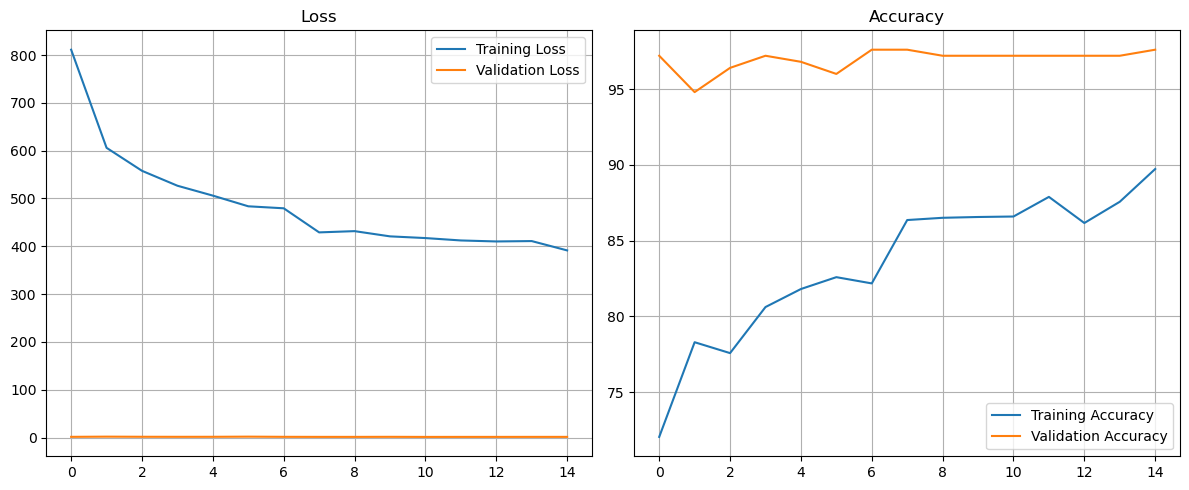

Test Accuracy: 99.60%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [36]:
# Import necessary libraries
from pathlib import Path
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix  
from timm import create_model

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/targeted_augmented_dataset")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Deeper unfreezing - unfreeze more serial_blocks4 + norm4 + head
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 4 blocks of serial_blocks4 + norm4 + head (serial_blocks4.4, 4.5, 4.6, 4.7)
for name, param in model.named_parameters():
    if any([k in name for k in ["serial_blocks4.4", "serial_blocks4.5", "serial_blocks4.6", "serial_blocks4.7", "norm4", "head"]]):
        param.requires_grad = True

model.to(device)

# Discriminative learning rates setup
base_lr = 1e-3
param_groups = []

# Group parameters by serial blocks
for name, param in model.named_parameters():
    if param.requires_grad:
        if "serial_blocks4.4" in name:
            param_groups.append({'params': [param], 'lr': base_lr * 0.1})  # Conservative
        elif "serial_blocks4.5" in name:
            param_groups.append({'params': [param], 'lr': base_lr * 0.3})  # Moderate-low
        elif "serial_blocks4.6" in name:
            param_groups.append({'params': [param], 'lr': base_lr * 0.6})  # Moderate-high
        elif "serial_blocks4.7" in name:
            param_groups.append({'params': [param], 'lr': base_lr * 0.8})  # Aggressive
        elif "norm4" in name:
            param_groups.append({'params': [param], 'lr': base_lr * 0.9})  # Near-aggressive
        elif "head" in name:
            param_groups.append({'params': [param], 'lr': base_lr})        # Most aggressive

optimizer = optim.Adam(param_groups, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.5)

# Count trainable parameters for reference
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Enhanced fine-tuning: {trainable_params:,}/{total_params:,} trainable params ({100*trainable_params/total_params:.1f}%)")

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")
    
    # Step the scheduler
    scheduler.step()

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [39]:
torch.save(model.state_dict(), "coat_lite_final_finetuning.pth")

In [ ]:
import torch, torch.nn as nn, numpy as np, cv2
from pathlib import Path
from PIL import Image
from timm import create_model
from torchvision import transforms
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model (exact same head as training) ---
num_classes = 50
model = create_model('coat_lite_medium', pretrained=False, num_classes=num_classes)
state = torch.load("coat_lite_final_finetuning.pth", map_location=device)
model.load_state_dict(state)
model.to(device).eval()

# --- Target layer (late conv) ---
# Primary: final patch embed conv. Fallback: last serial block conv if needed.
try:
    target_layers = [model.patch_embed4.proj]
except Exception:
    # If your timm version names differ, try the last block’s depthwise conv:
    target_layers = [model.serial_blocks4[-1].dwconv]

# --- Preprocess (use your val/test normalization) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_path = "../data/kaggle-dataset/archive/test/CLEARWING MOTH/1.jpg"
pil_img = Image.open(img_path).convert("RGB")
rgb_img = np.array(pil_img.resize((224, 224))) / 255.0
input_tensor = transform(pil_img).unsqueeze(0).to(device)

# --- Pick class to visualize (predicted by default) ---
with torch.no_grad():
    pred_idx = model(input_tensor).argmax(1).item()
targets = [ClassifierOutputTarget(pred_idx)]

# --- Score-CAM (no reshape_transform needed) ---
cam = ScoreCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

vis = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

out_path = Path("../cam_outputs/coat_lite_ft/score-cam-final-finetuning-clearwing-1.jpg")
out_path.parent.mkdir(parents=True, exist_ok=True)
cv2.imwrite(str(out_path), cv2.cvtColor((vis * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))


100%|██████████| 32/32 [01:11<00:00,  2.24s/it]

Saved: ..\cam_outputs\coat_lite_ft\score-cam-final-finetuning-clearwing-1.jpg
